In [1]:
# ! pip install openml

### Libraries

In [2]:
import openml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from tqdm import tqdm

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Models
from sklearn.ensemble import ExtraTreesClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc  
from scipy.stats import kendalltau

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from RandomSearch.RandomSearchWithMetrics import RandomSearchWithMetrics


In [3]:
# dataset 1 
dataset = openml.datasets.get_dataset(1504)

X1, y1, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# dataset 2
dataset = openml.datasets.get_dataset(1020)

X2, y2, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# dataset 3
dataset = openml.datasets.get_dataset(1120)

X3, y3, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# dataset 4
dataset = openml.datasets.get_dataset(1597)

X4, y4, _, _ = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# selecting from dataset 4 all rows where the target is 1 and 3000 rows where the target is 0
np.random.seed(42)
X4 = X4.loc[y4[y4 == '1'].index.union(y4[y4 == '0'].sample(3000).index)]
y4 = y4.loc[X4.index]
X4.index


Int64Index([    88,    183,    238,    254,    286,    321,    371,    517,
               541,    623,
            ...
            283834, 283845, 283864, 283877, 283987, 284068, 284096, 284189,
            284605, 284625],
           dtype='int64', length=3492)

### Deleting correlated columns, creating pipeline

Text(0.5, 1.0, 'Dataset 4 (1597)')

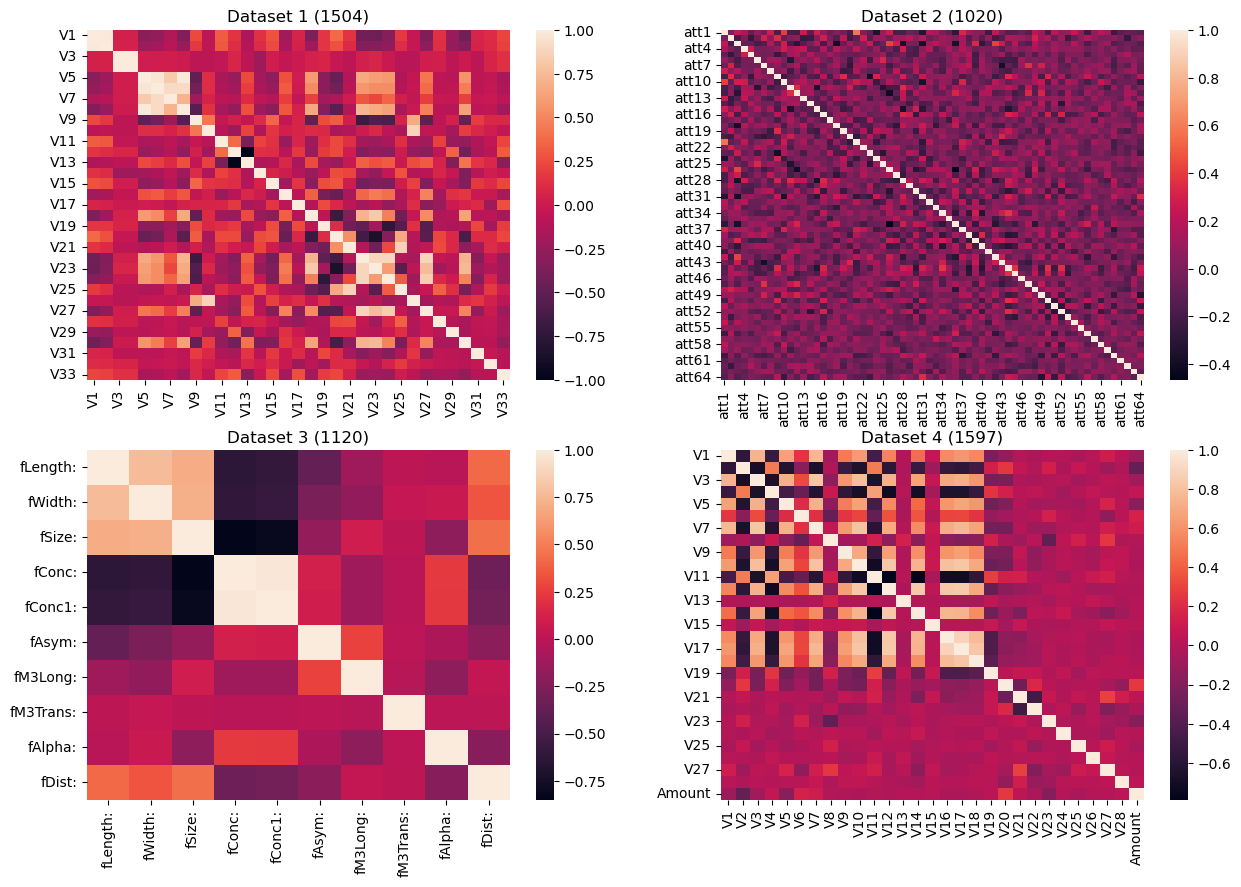

In [4]:
# correlation matrix
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

cor_matrix_1 = X1.corr()
cor_matrix_2 = X2.corr()
cor_matrix_3 = X3.corr()
cor_matrix_4 = X4.corr()

sns.heatmap(cor_matrix_1, ax = axes[0,0])
axes[0,0].set_title("Dataset 1 (1504)")

sns.heatmap(cor_matrix_2, ax = axes[0,1])
axes[0,1].set_title("Dataset 2 (1020)")

sns.heatmap(cor_matrix_3,  ax = axes[1,0])
axes[1,0].set_title("Dataset 3 (1120)")

sns.heatmap(cor_matrix_4, ax = axes[1,1])
axes[1,1].set_title("Dataset 4 (1597)")

Text(0.5, 1.0, 'Dataset 4 (1597)')

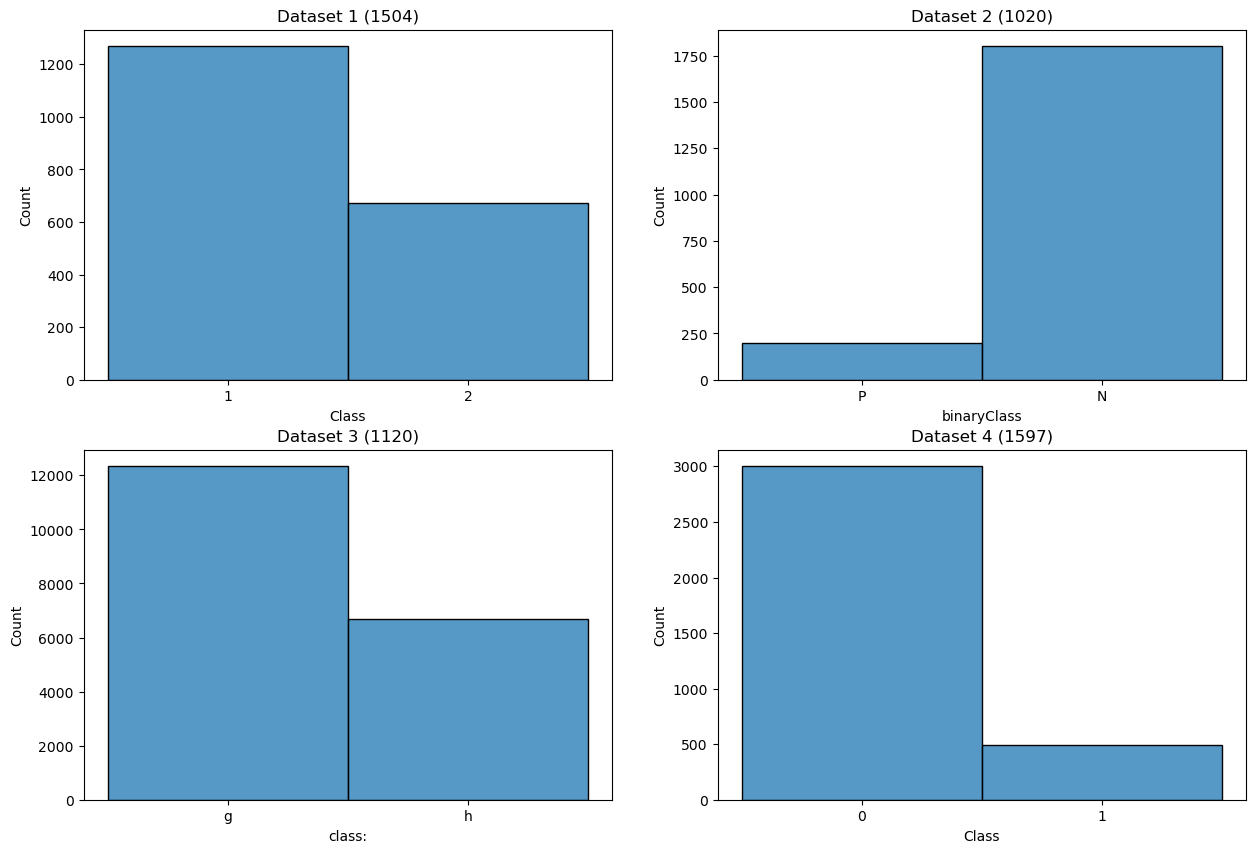

In [5]:
# distribution on targets
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

sns.histplot(y1, ax=axes[0,0])
axes[0,0].set_title("Dataset 1 (1504)")

sns.histplot(y2, ax=axes[0,1])
axes[0,1].set_title("Dataset 2 (1020)")

sns.histplot(y3, ax=axes[1,0])
axes[1,0].set_title("Dataset 3 (1120)")

sns.histplot(y4, ax=axes[1,1])
axes[1,1].set_title("Dataset 4 (1597)")

In [6]:
# change the target to (0,1) numeric
y1 = y1.replace({'1': 1, '0': 0}).astype(int)
y2 = y2.replace({'P': 1, 'N': 0}).astype(int)
y3 = y3.replace({'g': 0, 'h': 1}).astype(int)
y4 = y4.replace({'1': 1, '0': 0}).astype(int)

In [7]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

col_trans = ColumnTransformer([
    ('num_pipeline', num_pipeline, make_column_selector(dtype_include = np.number)),
    ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include = np.object_))
])

In [8]:
def are_correlated_removed(X, max_corr):
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > max_corr and i!=j:
                return corr_matrix.columns[i]
    return None 

class RemoveCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, max_correlation=0.75):
        self.max_correlation = max_correlation
        self.correlated_columns_ = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            
        res = are_correlated_removed(X, self.max_correlation)
        while res is not None:
            self.correlated_columns_.append(res)
            X = X.drop(columns=[res])
            res = are_correlated_removed(X, self.max_correlation)
        return X


Text(0.5, 1.0, 'Dataset 4 (1597)')

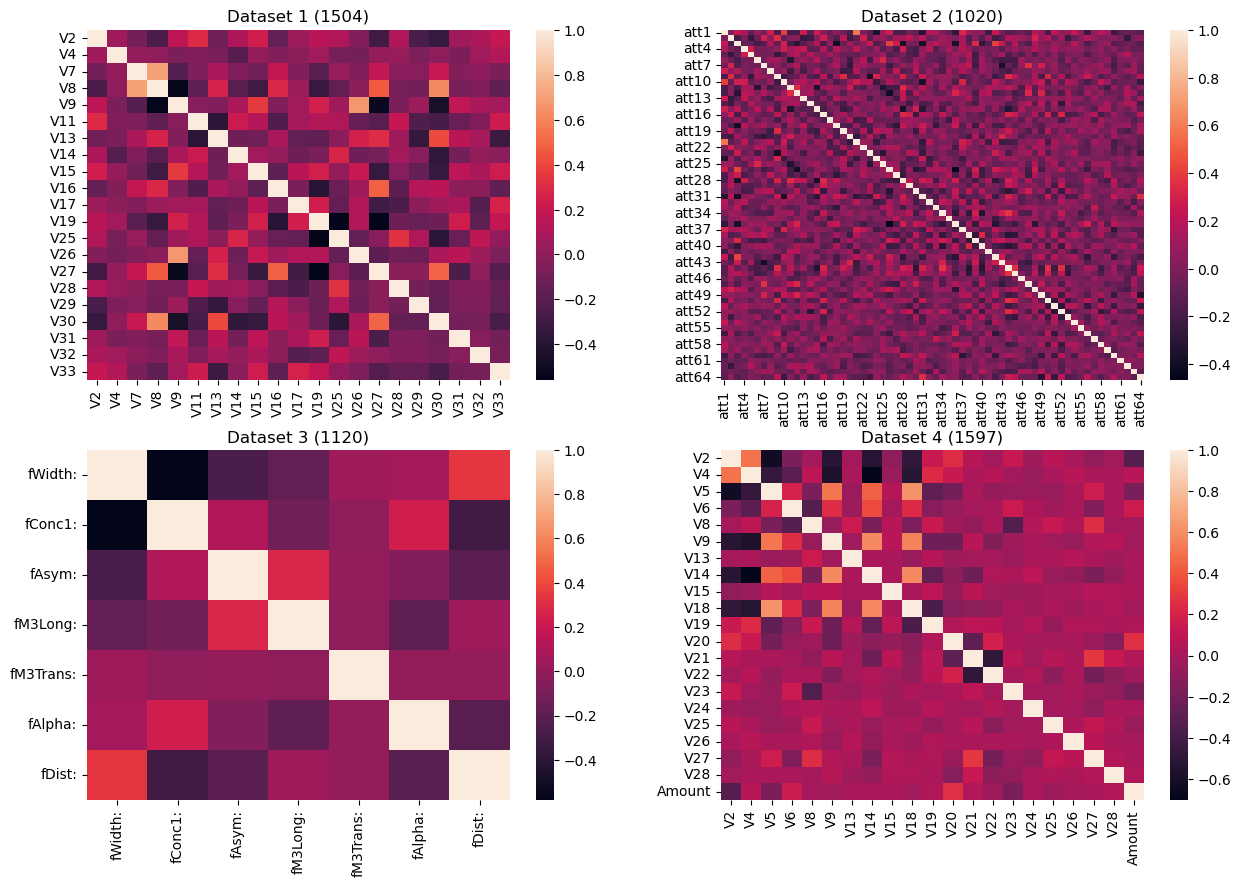

In [9]:
# we should delete correlated features before applying the pipeline, because a situation, 
# when in train set 2 features are correlated, but in test set they are not, can happen (max_correlation = 0.75)
X1 = RemoveCorrelatedFeatures().fit_transform(X1, 0.75)
X2 = RemoveCorrelatedFeatures().fit_transform(X2, 0.75)
X3 = RemoveCorrelatedFeatures().fit_transform(X3, 0.75)
X4 = RemoveCorrelatedFeatures().fit_transform(X4, 0.75)

# correlation matrix
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

cor_matrix_1 = X1.corr()
cor_matrix_2 = X2.corr()
cor_matrix_3 = X3.corr()
cor_matrix_4 = X4.corr()

sns.heatmap(cor_matrix_1, ax = axes[0,0])
axes[0,0].set_title("Dataset 1 (1504)")

sns.heatmap(cor_matrix_2, ax = axes[0,1])
axes[0,1].set_title("Dataset 2 (1020)")

sns.heatmap(cor_matrix_3,  ax = axes[1,0])
axes[1,0].set_title("Dataset 3 (1120)")

sns.heatmap(cor_matrix_4, ax = axes[1,1])
axes[1,1].set_title("Dataset 4 (1597)")


### Extra Trees Classifier + RandomSearch

In [10]:
params_extra_trees = {
    'model__n_estimators': [int(x) for x in np.linspace(start = 1, stop = 1000, num = 30)],
    'model__max_depth': [None] + [int(x) for x in np.linspace(start = 1, stop = 30, num = 15)],
    'model__min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 60, num = 20)],
    'model__min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 60, num = 20)],
    'model__min_weight_fraction_leaf': uniform(0.0, 0.5),
    'model__max_leaf_nodes': [None] + [int(x) for x in np.linspace(start = 2, stop = 60, num = 15)],
    'model__criterion': ['gini', 'entropy']
}

final_preprocessing_pipeline = Pipeline(steps=[
    ('preprocessing', col_trans),
    ('model', ExtraTreesClassifier())
])

In [11]:
# dataset 1
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X1,
    y=y1,
    cv=5
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_1.csv')

In [12]:
# dataset 2
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X2,
    y=y2,
    cv=5
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_2.csv')


In [13]:
# dataset 3
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X3,
    y=y3,
    cv=5
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_3.csv')


In [14]:
# dataset 4
random_search_extra_trees = RandomSearchWithMetrics(
    final_preprocessing_pipeline,
    params_extra_trees,
    n_iter=1000,
    X=X4,
    y=y4,
    cv=5
)

random_search_extra_trees.fit_and_evaluate()
random_search_extra_trees.save_results('RandomSearch/ExtraTreesClassifier/extra_trees_4.csv')
